In [1]:
import os
import math
import config
import random
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm

from utils import (
    create_img_grid,
    create_img_stack,
    extract_flxion_features,
    SpatialProjection
)

from model import ProjectionNet

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


2022-06-22 06:59:09.335292: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
data_dir = "../../data/dataset/raw/"
subjects = os.listdir(data_dir)

augmentation_levels = [11, 13, 9, 7, 0]
sp_augment = [
    SpatialProjection(
    img_dir="../../data/dataset/images/",
    # img_len=math.floor(config.IMG_LEN / 3),
    img_len=config.IMG_LEN,
    polyfit_degree=degree
)
    for degree in augmentation_levels ]

test_subject = "007"


In [3]:
train_features = []
train_images = []
train_labels = []
test_features = []
test_images = []
test_labels = []

for subject in tqdm(subjects):
    for gesture in config.GESTURES:
        gesture_dir = os.path.join(data_dir, subject, gesture)
        recordings = os.listdir(gesture_dir)
        for recording in recordings:
            _images = []
            file_path = os.path.join(gesture_dir, recording)

            data = pd.read_csv(file_path)
            data.drop(columns=["time"], inplace=True)
            data.drop(0, inplace=True)  # Remove first All-0 row

            if data.shape[0] == 0:
                continue

            # Flag for determining Trainning and Testing Samples
            for_training = random.randint(1, 100) <= 80

            for sp in sp_augment:
                for landmark in config.PROJECTION_LANDMARKS:
                    _images.extend(
                        sp.get_projection_images(
                            data=data.filter(regex=landmark),
                            subject=subject,
                            gesture=gesture
                        )
                    )

                _features = extract_flxion_features(data)

                # img = create_img_grid(_images, config.IMG_LEN)
                img = create_img_stack(_images[:3])

                if for_training:
                    train_features.append(_features)
                    train_images.append(img)
                    train_labels.append(config.GESTURES.index(gesture))
                else:
                    test_features.append(_features)
                    test_images.append(img)
                    test_labels.append(config.GESTURES.index(gesture))
                    break

    #         plt.imshow(img)
    #         plt.savefig("../assets/projection_demo.pdf")
    #         plt.show()

    #         break
    #     break
    # break


100%|██████████| 7/7 [08:28<00:00, 72.62s/it]


# Stack CNN Config

In [4]:
train_features = np.array(train_features)
train_images = np.array(train_images, dtype="uint8")
test_features = np.array(test_features)
test_images = np.array(test_images, dtype="uint8")

X_train = np.split(train_features, 5, axis=-1) + \
    [np.squeeze(img) for img in np.split(train_images, 3, axis=-1)]

X_test = np.split(test_features, 5, axis=-1) + \
    [np.squeeze(img) for img in np.split(test_images, 3, axis=-1)]

y_train = np.array(train_labels, dtype="uint8")
y_test = np.array(test_labels, dtype="uint8")

print(X_train[0].shape)
print(X_train[-1].shape)
print(X_test[0].shape)
print(X_test[-1].shape)
print(y_train.shape)
print(y_test.shape)


(4555, 150, 1)
(4555, 160, 160, 3)
(248, 150, 1)
(248, 160, 160, 3)
(4555,)
(248,)


In [5]:
# X = np.array(images, dtype="uint8")
# X = np.expand_dims(X[:, :, :, 0], axis=-1)
# # X = np.repeat(np.expand_dims(X, axis=-1), 3, axis=-1)
# y = np.array(labels, dtype="uint8")

# X_train = np.array(train_images, dtype="uint8")
# X_test = np.array(test_images, dtype="uint8")

# y_train = np.array(train_labels, dtype="uint8")
# y_test = np.array(test_labels, dtype="uint8")

# X_train = np.expand_dims(X_train[:, :, :, 0], axis=-1)
# X_test = np.expand_dims(X_test[:, :, :, 0], axis=-1)

# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

In [6]:
save_dir = f"../../data/dataset/processed/{test_subject}/"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

joblib.dump(X_train, os.path.join(save_dir, "X_train_stack_11.joblib"))
joblib.dump(y_train, os.path.join(save_dir, "y_train_stcak_11.joblib"))
joblib.dump(X_test, os.path.join(save_dir, "X_test_stack_11.joblib"))
joblib.dump(y_test, os.path.join(save_dir, "y_test_stack_11.joblib"))

['../../data/dataset/processed/007/y_test_stack_11.joblib']

In [7]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.33, random_state=42
# )


In [8]:
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# base_model = tf.keras.applications.MobileNetV2(
#     input_shape=(config.IMG_LEN, config.IMG_LEN, 3),
#     include_top=False,
#     weights="imagenet"
# )
# base_model.trainable = True
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# prediction_layer = tf.keras.layers.Dense(len(config.GESTURES))

# inputs = tf.keras.Input(shape=(config.IMG_LEN, config.IMG_LEN, 3))
# x = preprocess_input(inputs)
# x = base_model(x, training=True)
# x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.6)(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)


In [9]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Rescaling(
#         1/255.0,
#         input_shape=(config.IMG_LEN, config.IMG_LEN, config.N_CHANNELS)
#     ),
#     tf.keras.layers.Conv2D(16, (3, 3), activation="relu"),
#     tf.keras.layers.MaxPool2D((2, 2)),
#     tf.keras.layers.Conv2D(16, (3, 3), activation="relu"),
#     tf.keras.layers.MaxPool2D((2, 2)),
#     tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
#     tf.keras.layers.MaxPool2D((2, 2)),
#     tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
#     tf.keras.layers.MaxPool2D((2, 2)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation="relu"),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(len(config.GESTURES))
# ])


In [10]:
# import config
# from model import ConvMixer

# model = ConvMixer(
#     img_size=config.IMG_LEN,
#     in_channels=1,
#     n_classes=len(config.GESTURES),
#     n_filters=64,
#     depth=3,
#     kernel_size=5,
#     patch_size=2
# ).model()



In [17]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(config.IMG_LEN, config.IMG_LEN, 3),
    include_top=False,
    weights="imagenet"
)

model = ProjectionNet(
    img_size=config.IMG_LEN,
    segment_len=150,
    n_classes=len(config.GESTURES),
    base_model=base_model
).get_model()


In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config.LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [19]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=30,
        restore_best_weights=True
    )
]

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=700,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/700
143/143 [==============================] - 73s 481ms/step - loss: 1.9331 - accuracy: 0.3677 - val_loss: 1.1336 - val_accuracy: 0.6774
Epoch 2/700
143/143 [==============================] - 65s 457ms/step - loss: 0.9875 - accuracy: 0.6525 - val_loss: 0.5289 - val_accuracy: 0.8306
Epoch 3/700
143/143 [==============================] - 65s 457ms/step - loss: 0.7277 - accuracy: 0.7445 - val_loss: 0.4229 - val_accuracy: 0.8629
Epoch 4/700
143/143 [==============================] - 65s 457ms/step - loss: 0.5612 - accuracy: 0.8044 - val_loss: 0.3564 - val_accuracy: 0.8952
Epoch 5/700
143/143 [==============================] - 66s 458ms/step - loss: 0.4560 - accuracy: 0.8406 - val_loss: 0.3211 - val_accuracy: 0.9113
Epoch 6/700
143/143 [==============================] - 67s 469ms/step - loss: 0.4024 - accuracy: 0.8503 - val_loss: 0.3112 - val_accuracy: 0.8992
Epoch 7/700
143/143 [==============================] - 66s 459ms/step - loss: 0.3642 - accuracy: 0.8711 - val_loss: 0.3016 -

In [20]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 3s 366ms/step - loss: 0.2335 - accuracy: 0.9395


[0.23351506888866425, 0.9395161271095276]

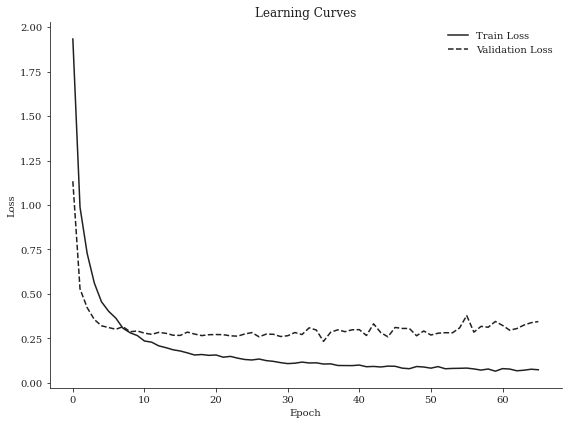

In [21]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    # "text.usetex": True,
    "font.family": "serif",
    # "font.serif": ["Computer Modern Roman"],
    "font.size": 22,
    "text.color": "#212121",
    "axes.edgecolor": "#212121",
    "xtick.color": "#212121",
    "ytick.color": "#212121",
    "axes.labelcolor": "#212121",
    'legend.frameon': False,
})

fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
ax.plot(history.history["loss"], "-", color="#212121", label="Train Loss")
ax.plot(history.history["val_loss"], "--",
        color="#212121", label="Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title("Learning Curves")
plt.legend()
plt.tight_layout()
plt.savefig("../assets/lc.png")
plt.show()


In [22]:
tf.keras.backend.clear_session()
